In [93]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [94]:
# set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [95]:
# Function to load and prepare your data

def load_data():

  data = pd.read_csv(f'feature_engineered_dataset.csv')

  X = data.drop(columns = ['remainder__Decided to Pursue MBA?'])
  y = data['remainder__Decided to Pursue MBA?']

  
  return X, y

In [96]:
from tensorflow.keras.layers import Input

def create_model(params):
    model = Sequential()

    # Input layer
    model.add(Input(shape=(X_train.shape[1],)))  # Explicitly define input shape
    model.add(Dense(
        units=params['units_1'],
        activation=params['activation'],
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=params['l1'], l2=params['l2'])
    ))

    # Add dropout after first layer
    model.add(Dropout(params['dropout_1']))

    # Hidden layers
    for i in range(params['n_layers']):
        model.add(Dense(
            units=params[f'units_{i+2}'],
            activation=params['activation'],
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=params['l1'], l2=params['l2'])
        ))
        model.add(Dropout(params[f'dropout_{i+1}']))

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer_name = params['optimizer']
    learning_rate = params['learning_rate']

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=params['momentum'])
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [97]:
# Object function for Optuna

def objective(trial):
    # Define hyperparametrs to tune
    params = {
        #network architecture
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'units_1': trial.suggest_int('units_1', 16, 256),
        'units_2': trial.suggest_int('units_2', 16, 256),
        'units_3': trial.suggest_int('units_3', 16, 256),
        'units_4': trial.suggest_int('units_4', 16, 256),
        'dropout_1': trial.suggest_float('dropout_1', 0.0, 0.5),
        'dropout_2': trial.suggest_float('dropout_2', 0.0, 0.5),
        'dropout_3': trial.suggest_float('dropout_3', 0.0, 0.5),
        'dropout_4': trial.suggest_float('dropout_4', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'elu', 'selu']),

        # Regularization
        'l1': trial.suggest_float('l1', 1e-8, 1e-3, log = True),
        'l2': trial.suggest_float('l2', 1e-8, 1e-3, log = True),

        #Optimization
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log = True),
        'momentum': trial.suggest_float('momentum', 0.0, 0.99),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'epochs': 100, # Fixed number of maximum epochs with early stopping
        
    }


    # use stratified k-fold cross-validation
    n_folds = 5
    skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)
    cv_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # calculate class weights if imbalance
        class_weights = compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(y_fold_train),
            y = y_fold_train
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

        # Create and train model
        model = create_model(params)

        # Define callbacks
        early_stopping = EarlyStopping(
            monitor = 'val_auc',
            patience = 10,
            restore_best_weights = True,
            mode = 'max'
        )

        reduce_lr = ReduceLROnPlateau(
            monitor = 'val_loss',
            factor = 0.2,
            patience = 5, 
            min_lr = 1e-6
        )

        # Train the model
        history = model.fit(
            X_fold_train, y_fold_train,
            epochs = params['epochs'],
            batch_size = params['batch_size'],
            validation_data = (X_fold_val, y_fold_val),
            class_weight = class_weight_dict,
            callbacks = [early_stopping, reduce_lr],
            verbose = 0
        )

        # Evaluate on validation set
        y_pred_proba = model.predict(X_fold_val, verbose = 0)
        y_preds = (y_pred_proba > 0.5).astype(int)

        # Get AUC score
        auc = roc_auc_score(y_fold_val, y_pred_proba)
        cv_scores.append(auc)

        # Free up score
        tf.keras.backend.clear_session()
        
    # Return the mean AUC score across all fold
    return np.mean(cv_scores)   

In [98]:
# Function to evaluate the best model

def evaluate_best_model(best_params, X_train, y_train, X_test, y_test):
    # Create a model with best paramas
    model = create_model(best_params)

    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(y_train),
        y = y_train
    )
    class_weight_dict = {
        i: weight for i, weight in enumerate(class_weights)
    }

    # Define the callbacks
    early_stopping = EarlyStopping(
        monitor = 'val_auc',
        patience = 15,
        restore_best_weights = True,
        mode = 'max'
    )

    reduce_lr = ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.2,
        patience = 5,
        min_lr = 1e-6
    )

    # Train the model 
    history = model.fit(
        X_train, y_train,
        epochs = best_params['epochs'],
        batch_size = best_params['batch_size'],
        validation_split = 0.2,
        class_weight = class_weight_dict,
        callbacks = [early_stopping, reduce_lr],
        verbose = 1
    )

    # Evaluate on test set
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print('\nFinal model evaluation on test set: ')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1:.4f}')
    print(f'AUC ROC: {auc:.4f}')


    # Plot training history
    plt.figure(figsize = (12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label = 'Training Loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label = 'Training AUC')
    plt.plot(history.history['val_auc'], label = 'Validation AUC')
    plt.title('AUC Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history

In [99]:
# Feature importance analsysis

def analyze_feature_importance(model, feature_names):
    # For neural noetwork, we can use permutation importance
    from sklearn.inspection import permutation_importance

    # Create a wrapper function for the model.predict method
    def model_predict_wrapper(X):
        return model.predict(X)

    # Calculate permutation importance
    result = permutation_importance(
        model_predict_wrapper, X_test, y_test,
        n_repeats = 10,
        random_state = 42,
        scoring = 'roc_auc'
    )

    # Create a DataFrame with feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': result.importance_mean,
        'std': result.importances_std
    })

    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending = False)

    # Plot feature importance 
    plt.figure(figure = (14, 8))
    sns.barplot(x = 'Importance', y = 'Feature', data = importance_df.head(20))
    plt.title('Top 20 Feature Imporance')
    plt.tight_layout()
    plt.show()

    return importance_df
                             

[I 2025-03-12 22:51:14,595] A new study created in memory with name: no-name-76892de6-c74c-4550-95ec-648937646681


Class Distribution: [4093 5907]
Class ratios: [0.4093 0.5907]


[I 2025-03-12 22:51:49,853] Trial 0 finished with value: 0.49698741895496923 and parameters: {'n_layers': 3, 'units_1': 110, 'units_2': 245, 'units_3': 99, 'units_4': 153, 'dropout_1': 0.26631202074213145, 'dropout_2': 0.26937138170416025, 'dropout_3': 0.2737242380108535, 'dropout_4': 0.2477265526996446, 'activation': 'elu', 'l1': 1.3636376833601165e-08, 'l2': 5.440316349665179e-07, 'optimizer': 'sgd', 'learning_rate': 0.0005807228697550683, 'momentum': 0.040599879206775866, 'batch_size': 64}. Best is trial 0 with value: 0.49698741895496923.
[I 2025-03-12 22:52:25,601] Trial 1 finished with value: 0.49950721928884523 and parameters: {'n_layers': 1, 'units_1': 233, 'units_2': 212, 'units_3': 98, 'units_4': 172, 'dropout_1': 0.22188576475862037, 'dropout_2': 0.33559402800797855, 'dropout_3': 0.04403970568028309, 'dropout_4': 0.19190865545649688, 'activation': 'elu', 'l1': 2.4387491578511125e-07, 'l2': 0.0005317191627027524, 'optimizer': 'rmsprop', 'learning_rate': 0.0002032489130348748, 


Best Hyperparameters:
n_layers: 2
units_1: 198
units_2: 193
units_3: 43
units_4: 145
dropout_1: 0.4382973740975018
dropout_2: 0.08726870129686393
dropout_3: 0.2275554230437318
dropout_4: 0.31448440654733717
activation: selu
l1: 8.11397369553156e-06
l2: 0.0001273375457283692
optimizer: adam
learning_rate: 0.005296693224245237
momentum: 0.6253114285571901
batch_size: 128
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4919 - auc: 0.4964 - loss: 1.0047 - val_accuracy: 0.5800 - val_auc: 0.5375 - val_loss: 0.7553 - learning_rate: 0.0053
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5132 - auc: 0.4976 - loss: 0.8324 - val_accuracy: 0.4819 - val_auc: 0.5097 - val_loss: 0.7735 - learning_rate: 0.0053
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5110 - auc: 0.5206 - loss: 0.7816 - val_accuracy: 0.5188 - val_auc: 0.5217 - val_loss: 0.7609 - learning_rate: 0.0053
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5073 - auc: 0

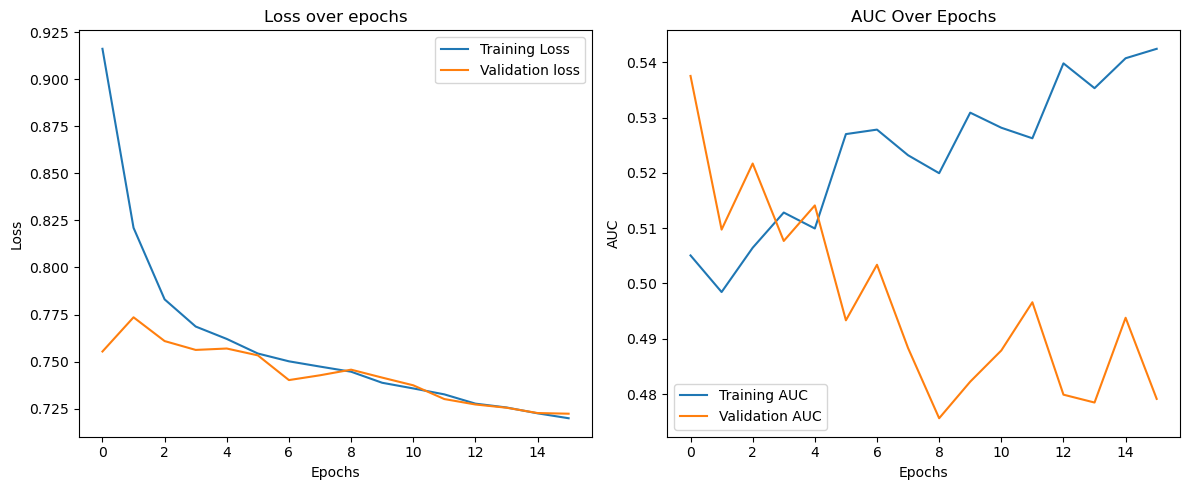

NameError: name 'feature_names' is not defined

In [100]:
# Main Execution 

if __name__ == '__main__':
    # Load data
    X, y = load_data()

    if X is None or y is None:
        print('Please provide your data loading code in the load_data function')
        exit()

     # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

     # Check class imbalance
    class_distribution = np.bincount(y)
    print(f'Class Distribution: {class_distribution}')
    print(f'Class ratios: {class_distribution / len(y)}')

    # Create an Optuna study 
    study = optuna.create_study(direction = 'maximize')
    study.optimize(objective, n_trials = 50) 

    # Get the best Hyperparameters
    best_params = study.best_params
    print('\nBest Hyperparameters:')
    for param, value in best_params.items():
        print(f'{param}: {value}')
    # Add the fixed epochs parameter
    best_params['epochs'] = 100

    # Evaluate the best model
    best_model, history = evaluate_best_model(
        best_params, X_train, y_train, X_test, y_test
    )

    # Analyze feature importance 
    feature_name = X.columns.tolist()
    importance_df = analyze_feature_importance(best_model, feature_name)

    # Print to 10 most importance feature
    print('\nTop 10 Most Important Features: ')
    print(importance_df.head(10))

    # Save the best model
    best_model.save('best_mba_decision_model.h5')
    print("\nModel saved as 'best_mba_decision_model.h5'")